# Titanic Survival Prediction

## 1. Import Libraries and Load Data

First, let's import the necessary libraries and load our training and testing datasets.

In [19]:
# 1. Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load the data
train_df = pd.read_csv(r"C:\Users\rolan\Desktop\titanic-hackathon-main\train.csv")
test_df = pd.read_csv(r"C:\Users\rolan\Desktop\titanic-hackathon-main\test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Exploratory Data Analysis (EDA)

Now, let's explore the data to understand its structure, find patterns, and identify missing values.

=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

=== MISSING VALUES ===
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin 

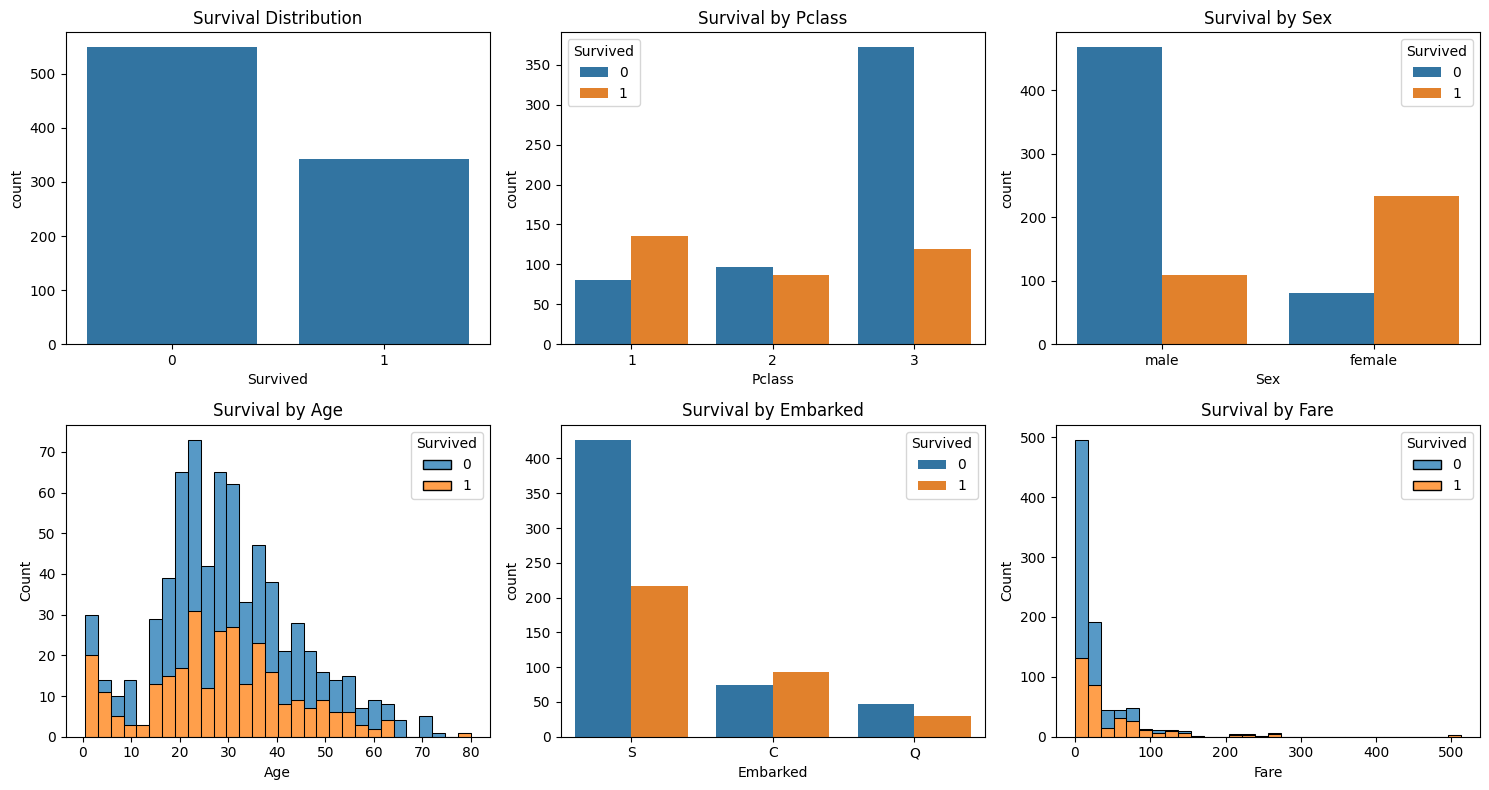

In [24]:
# 2. Exploratory Data Analysis (EDA)
print("=== BASIC INFO ===")
print(train_df.info())
print("\n=== MISSING VALUES ===")
print(train_df.isnull().sum())

# Visualizations simples
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Distribution')

plt.subplot(2, 3, 2)
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival by Pclass')

plt.subplot(2, 3, 3)
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Survival by Sex')

plt.subplot(2, 3, 4)
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title('Survival by Age')

plt.subplot(2, 3, 5)
sns.countplot(x='Embarked', hue='Survived', data=train_df)
plt.title('Survival by Embarked')

plt.subplot(2, 3, 6)
sns.histplot(data=train_df, x='Fare', hue='Survived', multiple='stack', bins=30)
plt.title('Survival by Fare')

plt.tight_layout()
plt.show()

## 3. Data Cleaning & Feature Engineering

Based on our EDA, we'll clean the data by handling missing values and create new features to improve our model's performance.

In [28]:
# 3. Data Cleaning & Feature Engineering
def feature_engineering(df):
    df_processed = df.copy()
    
    # Handle missing values - méthode simple
    df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)
    df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)
    df_processed['Fare'].fillna(df_processed['Fare'].median(), inplace=True)
    
    # Extraire le titre du nom
    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Regrouper les titres rares
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    df_processed['Title'] = df_processed['Title'].replace(rare_titles, 'Rare')
    df_processed['Title'] = df_processed['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df_processed['Title'] = df_processed['Title'].replace('Mme', 'Mrs')
    
    # Features de famille
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)
    
    # Cabin feature simple
    df_processed['HasCabin'] = (~df_processed['Cabin'].isnull()).astype(int)
    
    # Encoder les variables catégorielles
    le_sex = LabelEncoder()
    le_embarked = LabelEncoder()
    le_title = LabelEncoder()
    
    df_processed['Sex'] = le_sex.fit_transform(df_processed['Sex'])
    df_processed['Embarked'] = le_embarked.fit_transform(df_processed['Embarked'].astype(str))
    df_processed['Title'] = le_title.fit_transform(df_processed['Title'])
    
    # Supprimer colonnes inutiles
    columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    df_processed.drop([col for col in columns_to_drop if col in df_processed.columns], axis=1, inplace=True)
    
    return df_processed

# Appliquer le feature engineering
train_processed = feature_engineering(train_df)
test_processed = feature_engineering(test_df)

print("Processed train shape:", train_processed.shape)
print("Processed test shape:", test_processed.shape)
print("\nColonnes finales:", train_processed.columns.tolist())
train_processed.head()

Processed train shape: (891, 12)
Processed test shape: (418, 11)

Colonnes finales: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'HasCabin']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,HasCabin
0,0,3,1,22.0,1,0,7.2500,2,2,2,0,0
1,1,1,0,38.0,1,0,71.2833,0,3,2,0,1
2,1,3,0,26.0,0,0,7.9250,2,1,1,1,0
3,1,1,0,35.0,1,0,53.1000,2,3,2,0,1
4,0,3,1,35.0,0,0,8.0500,2,2,1,1,0


## 4. Model Training and Evaluation

It's time to choose a model, train it on our processed data, and see how well it performs.

=== RÉSULTATS VALIDATION CROISÉE ===
Scores: [0.86666667 0.80898876 0.82022472 0.83146067 0.7752809  0.83146067
 0.85393258 0.80898876 0.84269663 0.82022472]
Score moyen: 0.8260 (+/- 0.0490)

✅ Modèle Random Forest entraîné avec succès!


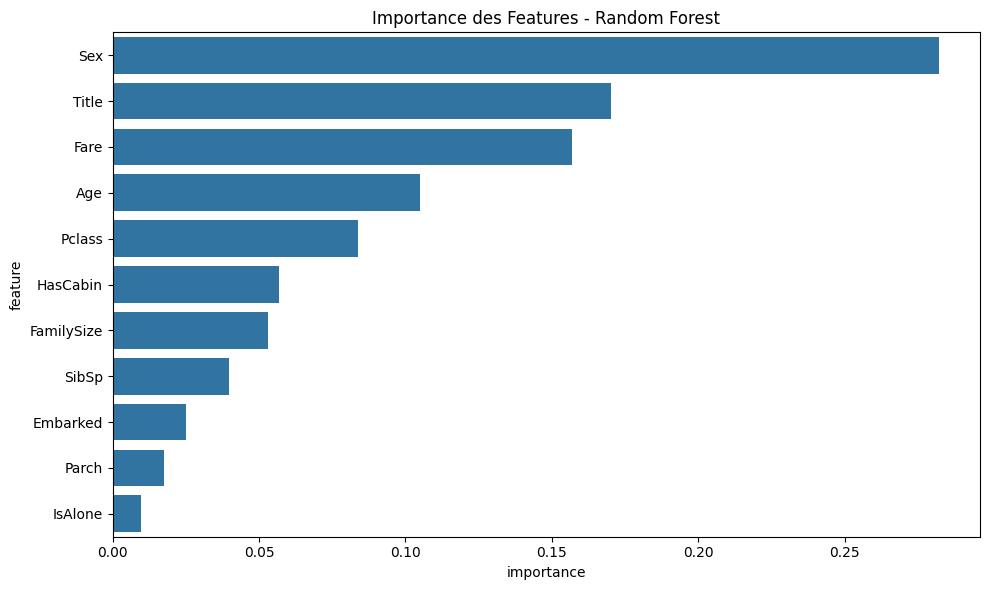

=== IMPORTANCE DES FEATURES ===
       feature  importance
1          Sex    0.282140
7        Title    0.170244
5         Fare    0.156936
2          Age    0.104995
0       Pclass    0.083889
10    HasCabin    0.056970
8   FamilySize    0.053153
3        SibSp    0.039720
6     Embarked    0.024895
4        Parch    0.017417
9      IsAlone    0.009641


In [ ]:
# 4. Model Training and Evaluation avec Random Forest
# Préparer les données
X = train_processed.drop('Survived', axis=1)
y = train_processed['Survived']

# Initialiser Random Forest avec de bons paramètres
rf_model = RandomForestClassifier(
    n_estimators=200,      # Nombre d'arbres
    max_depth=8,          # Profondeur max des arbres
    min_samples_split=6,  # Min samples pour diviser un nœud
    min_samples_leaf=2,   # Min samples dans une feuille
    max_features='sqrt',  # Nombre de features à considérer
    random_state=42,      # Pour la reproductibilité
    n_jobs=-1            # Utiliser tous les cœurs
)

# Validation croisée
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print("=== RÉSULTATS VALIDATION CROISÉE ===")
print(f"Scores: {cv_scores}")
print(f"Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Entraîner le modèle final sur toutes les données
rf_model.fit(X, y)
print("\n✅ Modèle Random Forest entraîné avec succès!")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importance des Features - Random Forest')
plt.tight_layout()
plt.show()

print("=== IMPORTANCE DES FEATURES ===")
print(feature_importance)

## 5. Create Submission File

Finally, we'll use our trained model to make predictions on the test set and generate the submission file in the required format.

In [37]:
# 5. Create Submission File
# Faire les prédictions sur le test set
test_predictions = rf_model.predict(test_processed)

# Créer le fichier de soumission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Sauvegarder
submission.to_csv('submission_rf.csv', index=False)

print("✅ Fichier de soumission créé avec succès!")
print(f"Taux de survie prédit: {test_predictions.mean():.2f}")
print(f"Nombre de survivants prédits: {test_predictions.sum()}")
print("\nAperçu des prédictions:")
print(submission.head(10))

# Aperçu des probabilités de prédiction
test_probabilities = rf_model.predict_proba(test_processed)
print(f"\nProbabilités de survie (5 premières): {test_probabilities[:5, 1]}")

✅ Fichier de soumission créé avec succès!
Taux de survie prédit: 0.38
Nombre de survivants prédits: 157

Aperçu des prédictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

Probabilités de survie (5 premières): [0.09103925 0.32650031 0.14747618 0.13034481 0.54097506]
